TWITTER SENTIMENT ANALYSIS

Importing all the libraries needed

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import snscrape.modules.twitter as sntwitter
from tqdm.notebook import tqdm
import spacy
import spacytextblob
from spacy import displacy
from spacytextblob.spacytextblob import SpacyTextBlob
import yfinance as yf
import datetime as dt
import pandas_datareader.data as web
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
import itertools

Defining the function to extract tweets

In [31]:
def collect_tweets(user, n_tweets, min_date):

    tweets = []

    for i, tweet in tqdm(enumerate(sntwitter.TwitterSearchScraper(f"from:{user}␣ 􏰑→since:{min_date}").get_items())):

        if i > n_tweets: 
            break

        tweets.append([tweet.date, tweet.content, tweet.likeCount, tweet.replyCount, tweet.retweetCount])
        
    tweets = pd.DataFrame(tweets, columns=['date','content', 'like Count', 'reply count', 'retweet count']) 
    return tweets 

TESLA ANALYSIS

As first company we have decided to analyze Tesla, trying to draw a link between its stock return and the tweets of the CEO Elon Musk. This choice is due to the fact the Musk is one of the most followed person on Twitter and thus is extremely influencial. Furthermore, allegation of market manipulation have already been moved towarda Musk so that it was interesting to check whether we could find ourselves such relation

We extract all the tweets from 2010 

In [32]:
Elon_Musk=collect_tweets(user="elonmusk", n_tweets=np.inf, min_date="2010-06-29")

Creating the environment for the nlp library to  run

SENTIMENT INDEX CREATION

In [33]:
nlp = spacy.load('en_core_web_md')

Here we have created a list of key-words to identify arguments related to Tesla. To do so we have also used the spacy library to find synonims trough pre.built word vectors both for the key word 'car' and the key word 'electric'. we store all the words in the list Tesla_syn

In [34]:
word1='electric'
word2='car'

ms1 = nlp.vocab.vectors.most_similar(
    np.asarray([nlp.vocab.vectors[nlp.vocab.strings[word1]]]), n=100)
ms2 = nlp.vocab.vectors.most_similar(
    np.asarray([nlp.vocab.vectors[nlp.vocab.strings[word2]]]), n=100)
Tesla_syn = [nlp.vocab.strings[w] for w in ms1[0][0]]
Tesla2_syn = [nlp.vocab.strings[w] for w in ms2[0][0]]
Tesla_syn.extend(Tesla2_syn)
Tesla_syn.extend(['Tesla', 'TESLA', 'self driving', 'Nasdaq', 'NASDAQ'])
print(Tesla_syn)

['electric', 'Non-Electric', 'Non-Electrical', 'Nuclear-Generated', 'SERVO', 'oil-fired', 'LIQUEFIED', 'gas', 'MOTOR', 'water-heater', 'power', 'POWE', 'Enery', 'energy', 'KITCHENWARE', 'solar', 'SOLAR-POWERED', 'GENERATORS', 'non-powered', 'electronic-based', 'consumer-electronics', 'ONAN', 'feul', 'HARMONICAS', 'HARMONICA', 'guitar', 'REWIRED', 'WOOD-BURNING', 'Two-Wheeler', 'Electro-Mechanical', 'PEDALING', 'ACOUSTICALLY', 'STEAMBATH', 'steam', 'Diesel-Electric', 'EQUIPEMENT', 'battery-powered', 'SKIMMER', 'heat', 'HEATS', 'FIXTURES', 'microwave-safe', 'cars', 'AUTOMOBILES', 'hybird', 'gasoline-powered', 'lights', 'Floodlights', 'iginition', 'VACUUMS', 'lead-acid', 'air-conditioner', 'ARMATURE', 'Sous-vide', 'TWO-CAR', 'INVERTER', 'steel', 'Cold-Rolled', 'TURBINES', 'wind', 'CRIMPED', 'wire', 'MAGNETIZED', 'non-metal', 'metal', 'Off-Highway', 'COMBUSTIBLES', 'car', 'AUTOMOBILE', 'battery', 'BATT', 'OPEN-HEARTH', 'OVERCHARGING', 'Motorcar', 'front-loading', 'SKIMMERS', 'INDUSTIAL', '

We add a pipeline to spacy to perform sentiment analysis

In [35]:
nlp.add_pipe('spacytextblob')

We create a new dataset where we filter only for tweets having at least ine word in common with the Tesla_syn list. As second step, for these tweets we perform a sentiment analysis to gather both positivity degree, range[-1,1] and subjectivity, range[0,1]

In [36]:
Tesla = Elon_Musk

sent=[]
subj=[]

for j in range(0,len(Elon_Musk)):
    
    row = Elon_Musk.iloc[j]
    content = row['content']
    
    if any(word in content for word in Tesla_syn):
        
        doc = nlp(content)
    
        sent.append(doc._.blob.polarity)
        subj.append(doc._.blob.subjectivity)
        
    else:
        
        Tesla = Tesla.drop(labels=j, axis=0)

We build our sentiment index. To do so we have decided to use a function of the form (1)Direct Effect + (2)Indirect Effect - (3)Debate.
- (1) measures the sentiment directly related to Musk followers and is constructed in the form (1 - Subjectivity) x Sentiment x Likes; in this way the greater weight will be given to tweets regarding positive news with a lot engagement, furthermore objective events have higher weight than subjective valuations as they can drive prices more significantly
- (2) measures the indirect sentiment, meaning the sentiment of people outside the circle of Musk's followers. Indeed, when a tweet is retweeted by a person, the original tweet will be seen by the followers of the latter. The difficult step was to quantify the number of people reached that would actually be interested in the tweet. To estimate such number we have used two data from Twitter: the number of average follower per person which will then have the tweet in their feed multiplied by the average Click-through rate per user. This metric is usually used to measure effectivness of ads, but in this context can be seen as the average number of retweets that really interest an external follower. The problem with both these data is that they are static and we couldn't find any time-series associated to that, so our analysis can be further improved
- (3) measures the debate around an argument. We expect that when the comment/like ratio is very high it means that the tweet is very controversial and divisive. we also multiply this factor for subjectivity in order to capture whether the divisive tweet is on an opinion or an event

Furthermore, we rescale all the factors in the range [-1,1] for direct(1) and indirect effect(2) and [0,1] for debate(3) factor.
Finally, we aggregate all the factors together

In [37]:
Tesla['Sentiment']=sent
Tesla['Subjectivity']=subj

Tesla.reset_index(inplace = True)
Tesla = Tesla.drop(columns=['index'])

Tesla['Objectivity']= 1 - Tesla['Subjectivity']
Tesla['Controversy']= Tesla['reply count']/Tesla['like Count']

Av_follower = 707
Av_CTR = 0.0164

Tesla['Direct Effect']=Tesla['Objectivity']*Tesla['Sentiment']*Tesla['like Count']
Tesla['Debate']=Tesla['Controversy']*Tesla['Subjectivity']*Tesla['retweet count']
Tesla['Indirect Effect']=Tesla['retweet count']*Av_follower*Av_CTR*Tesla['Sentiment']

MDirect=abs(Tesla['Direct Effect']).max()
MDebate = abs(Tesla['Debate']).max()
MIndirect = abs(Tesla['Indirect Effect']).max()

Tesla['Direct Effect']=Tesla['Direct Effect']/MDirect
Tesla['Debate'] = Tesla['Debate']/MDebate
Tesla['Indirect Effect'] = Tesla['Indirect Effect']/MIndirect

Tesla['Analysis']=Tesla['Direct Effect']+Tesla['Indirect Effect']-Tesla['Debate']

In [38]:
Tesla

,date,content,like Count,reply count,retweet count,Sentiment,Subjectivity,Objectivity,Controversy,Direct Effect,Debate,Indirect Effect,Analysis
0,2022-03-09 21:49:49+00:00,@FedorovMykhailo @OMarkarova You’re welcome. W...,38056,1436,3157,0.300000,0.650000,0.350000,0.037734,0.009860,0.018835,0.016864,0.007890
1,2022-03-07 07:08:48+00:00,@hiromichimizuno @GailAlfarATX @Tesla @TeslaSo...,7437,468,1447,0.000000,0.000000,1.000000,0.062929,0.000000,0.000000,0.000000,0.000000
2,2022-03-07 00:51:04+00:00,@GailAlfarATX @Tesla @TeslaSolar @japan @vigol...,7042,318,313,0.000000,0.000000,1.000000,0.045158,0.000000,0.000000,0.000000,0.000000
3,2022-03-06 23:57:02+00:00,Also nuclear is vastly better for global warmi...,164241,4496,13185,0.250000,0.250000,0.750000,0.027374,0.075989,0.021949,0.058694,0.112734
4,2022-03-06 23:27:00+00:00,"Hopefully, it is now extremely obvious that Eu...",311006,8602,43399,0.000000,0.433333,0.566667,0.027659,0.000000,0.126524,0.000000,-0.126524
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4916,2011-12-30 15:35:47+00:00,Not that this really matters. All current rock...,1329,26,186,-0.025000,0.475000,0.525000,0.019564,-0.000043,0.000420,-0.000083,-0.000546
4917,2011-12-24 01:41:33+00:00,The Russians are having some challenges with t...,20,25,15,0.500000,0.500000,0.500000,1.250000,0.000012,0.002280,0.000134,-0.002135
4918,2011-12-24 01:29:19+00:00,Kanye stopped by the SpaceX rocket factory tod...,114405,1305,8233,0.000000,0.000000,1.000000,0.011407,0.000000,0.000000,0.000000,0.000000
4919,2011-12-22 11:30:10+00:00,Model S options are out! Performance in red an...,697,49,72,-0.083333,0.216667,0.783333,0.070301,-0.000112,0.000267,-0.000107,-0.000486


Descriptive Statistics

In [39]:
Tesla.describe()

,like Count,reply count,retweet count,Sentiment,Subjectivity,Objectivity,Controversy,Direct Effect,Debate,Indirect Effect,Analysis
count,4921.000000,4921.000000,4921.000000,4921.000000,4921.000000,4921.000000,4921.000000,4921.000000,4921.000000,4921.000000,4921.000000
mean,15243.063808,762.429181,1463.056086,0.135211,0.387627,0.612373,0.080666,0.002206,0.007193,0.003081,-0.001906
std,43674.130065,3713.286174,6368.304206,0.251006,0.287305,0.287305,0.154684,0.017674,0.040229,0.025932,0.046739
min,2.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-0.065593,0.000000,-0.198130,-0.971947
25%,1074.000000,57.000000,65.000000,0.000000,0.100000,0.412500,0.030951,0.000000,0.000053,0.000000,-0.001003
50%,3215.000000,153.000000,207.000000,0.066667,0.408333,0.591667,0.046974,0.000039,0.000598,0.000085,0.000000
75%,10866.000000,481.000000,760.000000,0.250000,0.587500,0.900000,0.073006,0.000905,0.003198,0.001071,0.000455
max,864629.000000,120414.000000,146907.000000,1.000000,1.000000,1.000000,4.833333,1.000000,1.000000,1.000000,1.583202


Correlation

In [40]:
Tesla.corr(method='pearson')

,like Count,reply count,retweet count,Sentiment,Subjectivity,Objectivity,Controversy,Direct Effect,Debate,Indirect Effect,Analysis
like Count,1.000000,0.684859,0.872764,-0.001928,-0.013752,0.013752,-0.069167,0.420466,0.552982,0.498307,-0.040499
reply count,0.684859,1.000000,0.624862,-0.009196,-0.023442,0.023442,0.028563,0.286084,0.545350,0.275267,-0.208492
retweet count,0.872764,0.624862,1.000000,-0.015522,-0.006369,0.006369,-0.030781,0.328753,0.611280,0.510583,-0.118547
Sentiment,-0.001928,-0.009196,-0.015522,1.000000,0.376405,-0.376405,0.012984,0.187810,0.019083,0.212644,0.172573
Subjectivity,-0.013752,-0.023442,-0.006369,0.376405,1.000000,-1.000000,-0.009797,0.031029,0.123891,0.057322,-0.063099
Objectivity,0.013752,0.023442,0.006369,-0.376405,-1.000000,1.000000,0.009797,-0.031029,-0.123891,-0.057322,0.063099
Controversy,-0.069167,0.028563,-0.030781,0.012984,-0.009797,0.009797,1.000000,-0.026544,0.095663,-0.020752,-0.103890
Direct Effect,0.420466,0.286084,0.328753,0.187810,0.031029,-0.031029,-0.026544,1.000000,0.240656,0.775205,0.601101
Debate,0.552982,0.545350,0.611280,0.019083,0.123891,-0.123891,0.095663,0.240656,1.000000,0.377222,-0.560432
Indirect Effect,0.498307,0.275267,0.510583,0.212644,0.057322,-0.057322,-0.020752,0.775205,0.377222,1.000000,0.523272


We download the data for TSLA and compute the log_ret

In [41]:
start = dt.datetime(2011,12,1)
end = dt.datetime(2022,3,9)

TSLA_Return = web.DataReader('TSLA', "yahoo", start, end)
TSLA_Return['log_ret'] = np.log(TSLA_Return['Adj Close']) - np.log(TSLA_Return['Adj Close'].shift(1))
TSLA_Return['log_ret']=TSLA_Return['log_ret'].fillna(0)

In [42]:
print(TSLA_Return)

                  High         Low        Open       Close      Volume  \
Date                                                                     
2011-12-01    6.798000    6.396000    6.514000    6.520000   5151000.0   
2011-12-02    6.738000    6.480000    6.566000    6.660000   4014000.0   
2011-12-05    7.000000    6.686000    6.706000    6.884000   5800500.0   
2011-12-06    6.996000    6.806000    6.840000    6.974000   4759000.0   
2011-12-07    6.978000    6.760000    6.926000    6.838000   3371500.0   
...                ...         ...         ...         ...         ...   
2022-03-03  886.440002  832.599976  878.770020  839.289978  20541200.0   
2022-03-04  855.650024  825.159973  849.099976  838.289978  22333200.0   
2022-03-07  866.140015  804.570007  856.299988  804.580017  24164700.0   
2022-03-08  849.989990  782.169983  795.530029  824.400024  26799700.0   
2022-03-09  860.559998  832.010010  839.479980  858.969971  19672600.0   

             Adj Close   log_ret  
Da

We merge the two datasets matching the dates in order to have a joined dataframe containing the same number of observations only for market days when the stock is actually traded

In [43]:
def date_change(v):
    v = str(v.replace(tzinfo=None, hour=None))[:10]
    return v

In [44]:
Tesla['date']=Tesla['date'].map(date_change)
Tesla.rename({'date': 'Date'}, axis=1, inplace=True)
TSLA_Return.index = TSLA_Return.index.map(str)
TSLA_Return.index = TSLA_Return.index.map(lambda x : x[:10])
Joined=pd.merge(TSLA_Return, Tesla, on=['Date'], how='inner')

In [45]:
Joined = Joined.set_index('Date')
Joined

,High,Low,Open,Close,Volume,Adj Close,log_ret,content,like Count,reply count,retweet count,Sentiment,Subjectivity,Objectivity,Controversy,Direct Effect,Debate,Indirect Effect,Analysis
Date,,,,,,,,,,,,,,,,,,,
2011-12-01,6.798000,6.396000,6.514000,6.520000,5151000.0,6.520000,0.000000,Went to Iceland on Sat to ride bumper cars on ...,188,30,21,0.600000,0.733333,0.266667,0.159574,0.000074,0.000598,0.000224,-0.000299
2011-12-22,5.610000,5.460000,5.520000,5.554000,5047000.0,5.554000,0.007228,Model S options are out! Performance in red an...,697,49,72,-0.083333,0.216667,0.783333,0.070301,-0.000112,0.000267,-0.000107,-0.000486
2011-12-30,5.796000,5.650000,5.698000,5.712000,1699000.0,5.712000,-0.005935,Not that this really matters. All current rock...,1329,26,186,-0.025000,0.475000,0.525000,0.019564,-0.000043,0.000420,-0.000083,-0.000546
2012-01-11,5.676000,5.460000,5.524000,5.646000,3361500.0,5.646000,0.021845,The exec conf room at Tesla used to be called ...,311,30,67,0.350000,0.650000,0.350000,0.096463,0.000094,0.001022,0.000418,-0.000510
2012-01-12,5.724000,5.562000,5.696000,5.650000,3646500.0,5.650000,0.000708,Model S Performance powertrain produced so muc...,32,15,108,0.050000,0.400000,0.600000,0.468750,0.000002,0.004926,0.000096,-0.004827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-04,855.650024,825.159973,849.099976,838.289978,22333200.0,838.289978,-0.001192,@RenataKonkoly @MLUKBrandenburg @gigafactory_4...,4422,241,152,0.400000,0.729630,0.270370,0.054500,0.001180,0.001470,0.001083,0.000792
2022-03-04,855.650024,825.159973,849.099976,838.289978,22333200.0,838.289978,-0.001192,@MLUKBrandenburg @gigafactory_4 @Gf4Tesla @Gru...,11696,622,770,0.000000,0.000000,1.000000,0.053181,0.000000,0.000000,0.000000,0.000000
2022-03-07,866.140015,804.570007,856.299988,804.580017,24164700.0,804.580017,-0.041044,@hiromichimizuno @GailAlfarATX @Tesla @TeslaSo...,7437,468,1447,0.000000,0.000000,1.000000,0.062929,0.000000,0.000000,0.000000,0.000000


SERIES ANALYSIS

We plot the sentiment index built 

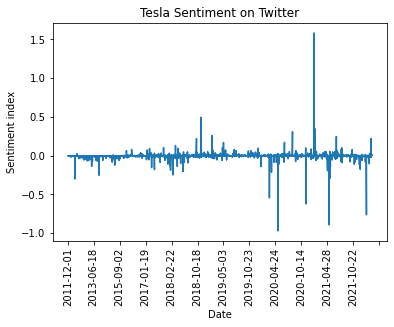

In [46]:
fig, ax = plt.subplots()

x = Joined.index
y = Joined['Analysis']

plt.plot(x,y)
plt.xlabel('Date')
plt.xticks(rotation = 90)

plt.ylabel('Sentiment index')
plt.title('Tesla Sentiment on Twitter')

ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.show()

According to the Ljung-Box test we fail to reject H0=autocorrelation

In [47]:
sm.stats.acorr_ljungbox(Joined['Analysis'], lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,13.090797,0.218639


We plot the ACF function to confirm the test

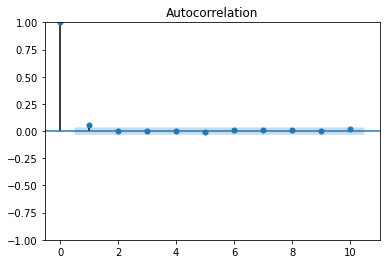

In [48]:
tsaplots.plot_acf(Joined['Analysis'], lags=10)
plt.show()

Better scaling, we can see that no lags exceeed the 95% interval for autocorrealtion

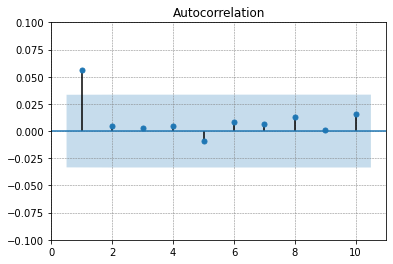

In [49]:
tsaplots.plot_acf(Joined['Analysis'], lags=10, alpha = 0.05, zero = False)

scale_factor = 0.1

ymin, ymax = plt.ylim()
plt.ylim(ymin * scale_factor, ymax * scale_factor)

plt.grid(which="major", color="grey", linestyle="--", linewidth=0.5)

plt.show()

We fit the ARIMA model picking the best model by minimizing the AIC. We find that the best fit is obtained using a (1,0,0) model

In [50]:
AIC = np.inf
p = q = d = range(0,3)
pdq = list(itertools.product(p, d, q))
for comb in pdq:
    model = ARIMA(Joined['Analysis'], order = comb)
    fit = model.fit()
    if fit.aic<AIC:
        AIC = fit.aic
        best_model = fit
        
summary_tesla_sentiment = best_model.summary()

C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no ass

In [51]:
print(summary_tesla_sentiment)

                               SARIMAX Results                                
Dep. Variable:               Analysis   No. Observations:                 3444
Model:                 ARIMA(1, 0, 0)   Log Likelihood                5650.975
Date:                Fri, 11 Mar 2022   AIC                         -11295.949
Time:                        00:45:21   BIC                         -11277.516
Sample:                             0   HQIC                        -11289.365
                               - 3444                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -2.177      0.029      -0.004      -0.000
ar.L1          0.0560      0.011      5.091      0.000       0.034       0.078
sigma2         0.0022    3.4e-06    647.182      0.0

We do the same analysis for the Tesla log-return

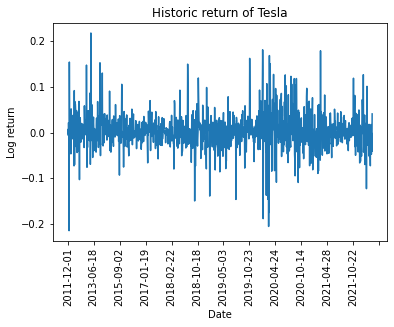

In [52]:
fig, ax = plt.subplots()

x = Joined.index
y = Joined['log_ret']

plt.plot(x,y)
plt.xlabel('Date')
plt.xticks(rotation = 90)

plt.ylabel('Log return')
plt.title('Historic return of Tesla')

ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.show()

The Ljung-Box test and the ACF function both highlight autocorrelation

In [53]:
sm.stats.acorr_ljungbox(Joined['log_ret'], lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,3127.047696,0.0


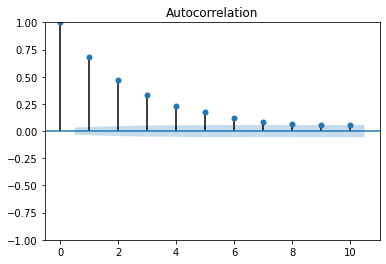

In [54]:
tsaplots.plot_acf(Joined['log_ret'], lags=10)
plt.show()

We chose the best model based on AIC criterion. Once again we find the (1,0,0) to be the best model, highlighting similarities with our sentiment index

In [55]:
AIC = np.inf
p = q = d = range(0,3)
pdq = list(itertools.product(p, d, q))
for comb in pdq:
    model = ARIMA(Joined['log_ret'], order = comb)
    fit = model.fit()
    if fit.aic<AIC:
        AIC = fit.aic
        best_model = fit
        
summary_tesla_ret = best_model.summary()

C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no ass

In [56]:
print(summary_tesla_ret)

                               SARIMAX Results                                
Dep. Variable:                log_ret   No. Observations:                 3444
Model:                 ARIMA(1, 0, 0)   Log Likelihood                7199.632
Date:                Fri, 11 Mar 2022   AIC                         -14393.264
Time:                        00:46:41   BIC                         -14374.831
Sample:                             0   HQIC                        -14386.680
                               - 3444                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.002      3.353      0.001       0.002       0.009
ar.L1          0.6803      0.008     89.152      0.000       0.665       0.695
sigma2         0.0009   9.54e-06     93.772      0.0

CONCLUSIONS

To check whether our index can be a good predictor for TSLA return we perform the Granger casuality test. We find the p-value to be 0.53 thus we fail to reject H0, so that our sentiment index doesn't seem to drive the price movement at lags up until 10

In [57]:
grangercausalitytests(Joined[['log_ret','Analysis']], maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9050  , p=0.5275  , df_denom=3413, df_num=10
ssr based chi2 test:   chi2=9.1054  , p=0.5221  , df=10
likelihood ratio test: chi2=9.0933  , p=0.5233  , df=10
parameter F test:         F=0.9050  , p=0.5275  , df_denom=3413, df_num=10


{10: ({'ssr_ftest': (0.9049716006315937, 0.5275234922344956, 3413.0, 10),
   'ssr_chi2test': (9.105398407761186, 0.5221309992573039, 10),
   'lrtest': (9.093348027090542, 0.523268054470561, 10),
   'params_ftest': (0.9049716006316973, 0.5275234922344252, 3413.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1

We also carried out the opposite analysis, meaning checking whether the price movement can explain the sentiment index at lags up to 10. In this case the p-value is very small, p-value=0.001, thus we reject H0 meaning there exist casuality between the two series, even if in the opposite direction then expected. Thus, we can conclude that knowing the TSLA stock movements is useful for predicting the future sentiment on Twitter around this topic.

In [58]:
grangercausalitytests(Joined[['Analysis','log_ret']], maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9786  , p=0.0010  , df_denom=3413, df_num=10
ssr based chi2 test:   chi2=29.9697 , p=0.0009  , df=10
likelihood ratio test: chi2=29.8397 , p=0.0009  , df=10
parameter F test:         F=2.9786  , p=0.0010  , df_denom=3413, df_num=10


{10: ({'ssr_ftest': (2.9786412874450643, 0.0009618654502133523, 3413.0, 10),
   'ssr_chi2test': (29.969687023399793, 0.0008664756733630142, 10),
   'lrtest': (29.839665142015292, 0.0009099200327881797, 10),
   'params_ftest': (2.978641287445069, 0.0009618654502131882, 3413.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

VIRGIN GALACTIC

In [59]:
Rich_Branson=collect_tweets(user="richardbranson", n_tweets=np.inf, min_date="2019-10-28")

In [60]:
word1='space'
word2='flight'

ms1 = nlp.vocab.vectors.most_similar(
    np.asarray([nlp.vocab.vectors[nlp.vocab.strings[word1]]]), n=100)
ms2 = nlp.vocab.vectors.most_similar(
    np.asarray([nlp.vocab.vectors[nlp.vocab.strings[word2]]]), n=100)
VG_syn = [nlp.vocab.strings[w] for w in ms1[0][0]]
VG2_syn = [nlp.vocab.strings[w] for w in ms2[0][0]]
VG_syn.extend(VG2_syn)
VG_syn.extend(['Virgin Galactic', 'SPCE', 'flight to space', 'Nyse', 'NYSE'])
print(VG_syn)

['SPACE', 'space', 'SPACES', 'ROOM', 'room', 'storage', 'safe-keeping', 'AREA', 'area', 'FLOOR', 'inside', 'INside', 'BUIDING', 'building', 'Medium-size', 'large', 'LARGER', 'livng', 'living', 'compactified', 'where', 'Where', 'WHERe', 'HALF-FILLED', 'square', 'sq.', 'OPen', 'open', 'APOGEE', 'ouside', 'outside', 'PLACE', 'place', 'BEYOND', 'beyond', 'HOMEWORLD', 'planet', 'RELOCATE', 'move', 'Possiblities', 'MOVERS', 'moving', 'occupy', 'Situate', 'FREE-FLYING', 'COSMOS', 'universe', 'INTERIORS', 'sub-basement', 'SCALED-DOWN', 'Accomodate', 'Withing', 'within', 'OBJECTS', 'CONSTELLATIONS', 'there', 'There', 'THere', 'ENVIROMENT', 'POSSIBLE', 'possible', 'future', 'FUTURE', 'ARCHWAYS', 'stucture', 'vitual', 'virtual', 'intothe', 'Into', 'into', 'AMBIANCE', 'location', 'LOCATION', 'VALET', 'REOCCUPIED', 'enough', 'ENOUGH', 'Enough', 'Side-By-Side', 'One-Room', 'small', 'one-person', 'CONCEPT', 'gound', 'ground', 'demensions', 'Wall-To-Wall', 'house', 'Hous', 'TWO-CAR', 'WALL', 'wall', '

In [61]:
VG = Rich_Branson

sent=[]
subj=[]

for j in range(0,len(Rich_Branson)):
    
    row = Rich_Branson.iloc[j]
    content = row['content']
    
    if any(word in content for word in VG_syn):
        
        doc = nlp(content)
    
        sent.append(doc._.blob.polarity)
        subj.append(doc._.blob.subjectivity)
        
    else:
        
        VG = VG.drop(labels=j, axis=0)

In [62]:
VG['Sentiment']=sent
VG['Subjectivity']=subj

VG.reset_index(inplace = True)
VG = VG.drop(columns=['index'])

VG['Objectivity']= 1 - VG['Subjectivity']
VG['Controversy']= VG['reply count']/VG['like Count']

Av_follower = 707
Av_CTR = 0.0164

VG['Direct Effect']=VG['Objectivity']*VG['Sentiment']*VG['like Count']
VG['Debate']=VG['Controversy']*VG['Subjectivity']*VG['retweet count']
VG['Indirect Effect']=VG['retweet count']*Av_follower*Av_CTR*VG['Sentiment']

MDirect=abs(VG['Direct Effect']).max()
MDebate = abs(VG['Debate']).max()
MIndirect = abs(VG['Indirect Effect']).max()

VG['Direct Effect']=VG['Direct Effect']/MDirect
VG['Debate'] = VG['Debate']/MDebate
VG['Indirect Effect'] = VG['Indirect Effect']/MIndirect

VG['Analysis']=VG['Direct Effect']+VG['Indirect Effect']-VG['Debate']

In [63]:
VG

,date,content,like Count,reply count,retweet count,Sentiment,Subjectivity,Objectivity,Controversy,Direct Effect,Debate,Indirect Effect,Analysis
0,2022-03-08 19:39:52+00:00,The solutions all exist. I believe the global ...,197,24,26,0.152778,0.329167,0.670833,0.121827,0.002644,0.003844,0.001198,-0.000001
1,2022-03-08 19:39:48+00:00,"UK and EU must do the same. Yes, economic repe...",98,14,18,0.097222,0.406349,0.593651,0.142857,0.000741,0.003852,0.000528,-0.002584
2,2022-03-08 19:39:48+00:00,Heartened to see the US government ban the imp...,544,80,80,0.050000,0.475000,0.525000,0.147059,0.001870,0.020602,0.001207,-0.017525
3,2022-03-08 18:04:52+00:00,Partnering is the perfect book to learn how to...,53,4,7,0.744444,0.827778,0.172222,0.075472,0.000890,0.001612,0.001572,0.000850
4,2022-03-08 18:04:51+00:00,I’ve spent 18 years in awe of @JeanOelwang – w...,15,2,1,0.092857,0.317857,0.682143,0.133333,0.000124,0.000156,0.000028,-0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2019-10-29 09:45:09+00:00,Tansghart was the first @EveBranson Foundation...,228,10,22,0.147727,0.547980,0.452020,0.043860,0.001994,0.001949,0.000981,0.001025
503,2019-10-28 18:25:08+00:00,Celebrating the first day of trading for the w...,390,34,81,0.100000,0.366667,0.633333,0.087179,0.003235,0.009546,0.002444,-0.003867
504,2019-10-28 18:03:38+00:00,@virgingalactic @NYSE What a great day – Congr...,45,3,8,0.800000,0.750000,0.250000,0.066667,0.001179,0.001475,0.001931,0.001635
505,2019-10-28 17:25:06+00:00,"For the first time, anyone will have the chanc...",181,21,35,0.125000,0.216667,0.783333,0.116022,0.002321,0.003244,0.001320,0.000397


From the descriptive statistics we can see that this series is shorter than the Tesla one. This is due that Virgin Galactic has been enlisted quite recently so fewer observations are available

In [64]:
VG.describe()

,like Count,reply count,retweet count,Sentiment,Subjectivity,Objectivity,Controversy,Direct Effect,Debate,Indirect Effect,Analysis
count,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
mean,1195.706114,84.946746,162.579882,0.270463,0.482720,0.517280,0.113271,0.018297,0.020996,0.014185,0.011486
std,5127.771996,287.164369,854.957720,0.275771,0.281126,0.281126,0.085279,0.096682,0.085231,0.078490,0.127716
min,2.000000,0.000000,0.000000,-0.505556,0.000000,0.000000,0.000000,-0.039457,0.000000,-0.034756,-0.818488
25%,157.500000,15.000000,25.500000,0.035417,0.300000,0.304015,0.068068,0.000000,0.001882,0.000000,-0.003042
50%,275.000000,28.000000,40.000000,0.250000,0.500000,0.500000,0.096774,0.002680,0.006170,0.002647,0.000000
75%,485.500000,56.000000,69.000000,0.440633,0.695985,0.700000,0.136606,0.006574,0.013356,0.005513,0.003014
max,63779.000000,3493.000000,15249.000000,1.000000,1.000000,1.000000,1.018303,1.000000,1.000000,1.000000,1.246262


Another remark is that in this case the Direct and Indirect effects in this case are way more relevant that the Debate factor in our index construction

In [65]:
VG.corr(method='pearson')

,like Count,reply count,retweet count,Sentiment,Subjectivity,Objectivity,Controversy,Direct Effect,Debate,Indirect Effect,Analysis
like Count,1.000000,0.824081,0.916274,0.060908,0.025225,-0.025225,-0.115693,0.903815,0.719009,0.924729,0.772673
reply count,0.824081,1.000000,0.824998,0.002134,-0.007714,0.007714,0.113629,0.610875,0.792117,0.678983,0.351100
retweet count,0.916274,0.824998,1.000000,0.012935,-0.007430,0.007430,-0.079237,0.755195,0.744521,0.836211,0.588742
Sentiment,0.060908,0.002134,0.012935,1.000000,0.563021,-0.563021,-0.024673,0.163962,0.060260,0.153086,0.177988
Subjectivity,0.025225,-0.007714,-0.007430,0.563021,1.000000,-1.000000,0.014066,0.074739,0.118676,0.093256,0.034692
Objectivity,-0.025225,0.007714,0.007430,-0.563021,-1.000000,1.000000,-0.014066,-0.074739,-0.118676,-0.093256,-0.034692
Controversy,-0.115693,0.113629,-0.079237,-0.024673,0.014066,-0.014066,1.000000,-0.122069,0.181782,-0.102347,-0.276618
Direct Effect,0.903815,0.610875,0.755195,0.163962,0.074739,-0.074739,-0.122069,1.000000,0.643123,0.941987,0.906735
Debate,0.719009,0.792117,0.744521,0.060260,0.118676,-0.118676,0.181782,0.643123,1.000000,0.759268,0.286122
Indirect Effect,0.924729,0.678983,0.836211,0.153086,0.093256,-0.093256,-0.102347,0.941987,0.759268,1.000000,0.820963


In [66]:
start = dt.datetime(2019,10,28)
end = dt.datetime(2022,3,9)

Virgin_Galactic_Return = web.DataReader('SPCE', "yahoo", start, end)
Virgin_Galactic_Return['log_ret'] = np.log(Virgin_Galactic_Return['Adj Close']) - np.log(Virgin_Galactic_Return['Adj Close'].shift(1))
Virgin_Galactic_Return['log_ret']=Virgin_Galactic_Return['log_ret'].fillna(0)

In [67]:
VG['date']=VG['date'].map(date_change)
VG.rename({'date': 'Date'}, axis=1, inplace=True)
Virgin_Galactic_Return.index = Virgin_Galactic_Return.index.map(str)
Virgin_Galactic_Return.index = Virgin_Galactic_Return.index.map(lambda x : x[:10])
Joined=pd.merge(Virgin_Galactic_Return, VG, on=['Date'], how='inner')

In [68]:
Joined = Joined.set_index('Date')
Joined

,High,Low,Open,Close,Volume,Adj Close,log_ret,content,like Count,reply count,retweet count,Sentiment,Subjectivity,Objectivity,Controversy,Direct Effect,Debate,Indirect Effect,Analysis
Date,,,,,,,,,,,,,,,,,,,
2019-10-28,11.790,11.79,11.79,11.79,0,11.79,0.000000,Celebrating the first day of trading for the w...,390,34,81,0.100000,0.366667,0.633333,0.087179,0.003235,0.009546,0.002444,-0.003867
2019-10-28,11.790,11.79,11.79,11.79,0,11.79,0.000000,@virgingalactic @NYSE What a great day – Congr...,45,3,8,0.800000,0.750000,0.250000,0.066667,0.001179,0.001475,0.001931,0.001635
2019-10-28,11.790,11.79,11.79,11.79,0,11.79,0.000000,"For the first time, anyone will have the chanc...",181,21,35,0.125000,0.216667,0.783333,0.116022,0.002321,0.003244,0.001320,0.000397
2019-10-28,11.790,11.79,11.79,11.79,0,11.79,0.000000,Delighted to be on the @NYSE trading room floo...,327,28,59,0.190000,0.440000,0.560000,0.085627,0.004557,0.008195,0.003382,-0.000256
2019-10-29,12.090,10.50,12.04,10.99,6324000,10.99,-0.070266,@adambain Thanks for joining us on the journey...,12,0,0,0.250000,0.200000,0.800000,0.000000,0.000314,0.000000,0.000000,0.000314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-08,7.829,7.05,7.40,7.42,17984700,7.42,0.008119,The solutions all exist. I believe the global ...,197,24,26,0.152778,0.329167,0.670833,0.121827,0.002644,0.003844,0.001198,-0.000001
2022-03-08,7.829,7.05,7.40,7.42,17984700,7.42,0.008119,"UK and EU must do the same. Yes, economic repe...",98,14,18,0.097222,0.406349,0.593651,0.142857,0.000741,0.003852,0.000528,-0.002584
2022-03-08,7.829,7.05,7.40,7.42,17984700,7.42,0.008119,Heartened to see the US government ban the imp...,544,80,80,0.050000,0.475000,0.525000,0.147059,0.001870,0.020602,0.001207,-0.017525


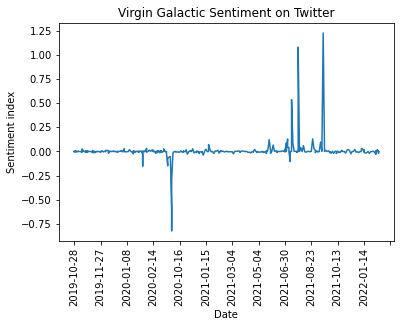

In [69]:
fig, ax = plt.subplots()

x = Joined.index
y = Joined['Analysis']

plt.plot(x,y)
plt.xlabel('Date')
plt.xticks(rotation = 90)

plt.ylabel('Sentiment index')
plt.title('Virgin Galactic Sentiment on Twitter')

ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.show()

From the Ljung-Box test and ACF function we reject H0, thus there exist autocorrelation

In [70]:
sm.stats.acorr_ljungbox(Joined['Analysis'], lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,29.711957,0.000955


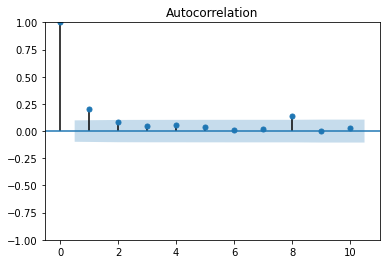

In [71]:
tsaplots.plot_acf(Joined['Analysis'], lags=10)
plt.show()

Fitting for the best ARIMA model we find once agin a (1,0,0) to be the best model minimizing the AIC criterion

In [72]:
AIC = np.inf
p = q = d = range(0,3)
pdq = list(itertools.product(p, d, q))
for comb in pdq:
    model = ARIMA(Joined['Analysis'], order = comb)
    fit = model.fit()
    if fit.aic<AIC:
        AIC = fit.aic
        best_model = fit
        
summary_VG_sentiment = best_model.summary()

C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no ass

In [73]:
print(summary_VG_sentiment)

                               SARIMAX Results                                
Dep. Variable:               Analysis   No. Observations:                  395
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 342.599
Date:                Fri, 11 Mar 2022   AIC                           -679.199
Time:                        00:48:48   BIC                           -667.262
Sample:                             0   HQIC                          -674.469
                                - 395                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.009      0.396      0.692      -0.014       0.022
ar.L1          0.2002      0.019     10.305      0.000       0.162       0.238
sigma2         0.0103      0.000     67.686      0.0

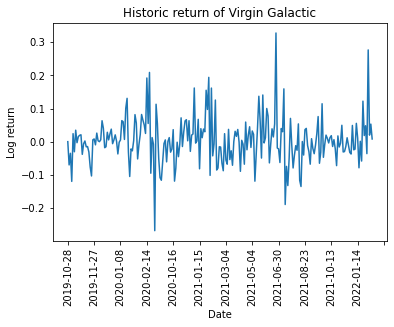

In [74]:
fig, ax = plt.subplots()

x = Joined.index
y = Joined['log_ret']

plt.plot(x,y)
plt.xlabel('Date')
plt.xticks(rotation = 90)

plt.ylabel('Log return')
plt.title('Historic return of Virgin Galactic')

ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.show()

Also the returns of VG exhibit serial autocorrelation

In [75]:
sm.stats.acorr_ljungbox(Joined['log_ret'], lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,97.292052,1.895444e-16


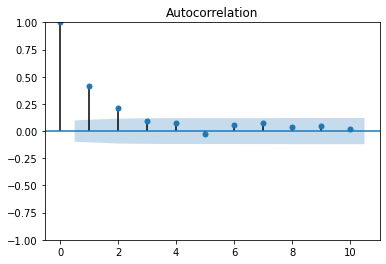

In [76]:
tsaplots.plot_acf(Joined['log_ret'], lags=10)
plt.show()

Fittinf the ARIMA model, we find the (2,0,1) to be the best model

In [77]:
AIC = np.inf
p = q = d = range(0,3)
pdq = list(itertools.product(p, d, q))
for comb in pdq:
    model = ARIMA(Joined['log_ret'], order = comb)
    fit = model.fit()
    if fit.aic<AIC:
        AIC = fit.aic
        best_model = fit
        
summary_VG_ret = best_model.summary()

C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\aleta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no ass

In [78]:
print(summary_VG_ret)

                               SARIMAX Results                                
Dep. Variable:                log_ret   No. Observations:                  395
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 540.850
Date:                Fri, 11 Mar 2022   AIC                          -1071.700
Time:                        00:49:27   BIC                          -1051.806
Sample:                             0   HQIC                         -1063.818
                                - 395                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.006      0.321      0.748      -0.009       0.013
ar.L1         -0.5383      0.053    -10.199      0.000      -0.642      -0.435
ar.L2          0.4262      0.029     14.916      0.0

By looking at Granger casuality we fail to reject H0, so that no casuality is present in both directions

In [79]:
grangercausalitytests(Joined[['log_ret','Analysis']], maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.5445  , p=0.8581  , df_denom=364, df_num=10
ssr based chi2 test:   chi2=5.7592  , p=0.8351  , df=10
likelihood ratio test: chi2=5.7165  , p=0.8385  , df=10
parameter F test:         F=0.5445  , p=0.8581  , df_denom=364, df_num=10


{10: ({'ssr_ftest': (0.544502286173073, 0.8581201926920843, 364.0, 10),
   'ssr_chi2test': (5.759158796061349, 0.8350754513369539, 10),
   'lrtest': (5.7165083962690915, 0.838492067790676, 10),
   'params_ftest': (0.5445022861730668, 0.8581201926920881, 364.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           1.,

In [80]:
grangercausalitytests(Joined[['Analysis','log_ret']], maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1227  , p=0.3438  , df_denom=364, df_num=10
ssr based chi2 test:   chi2=11.8745 , p=0.2935  , df=10
likelihood ratio test: chi2=11.6950 , p=0.3060  , df=10
parameter F test:         F=1.1227  , p=0.3438  , df_denom=364, df_num=10


{10: ({'ssr_ftest': (1.1226791482857374, 0.34381888665874677, 364.0, 10),
   'ssr_chi2test': (11.87449099148376, 0.293544200048443, 10),
   'lrtest': (11.695049834624342, 0.30598399454562086, 10),
   'params_ftest': (1.1226791482857343, 0.3438188866587572, 364.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           